# Constraint Graphs

This tutorial will reproduce the figures and examples that are in the <i>Finding the optimal Bayesian network given a constraint graph</i> paper in <i>PeerJ</i>.

In [1]:
import matplotlib
matplotlib.use('pdf')
%pylab inline


import seaborn; seaborn.set_style('whitegrid')
import pandas, itertools, networkx, time
from pomegranate import *

Populating the interactive namespace from numpy and matplotlib


## 4.1 Acyclic Constraint Graphs Can Model the Global Stock Market

First we need to load up the data from the various stocks and get it into the format of a single matrix instead of separate time series.

In [2]:
NYSE = ["AAPL","XOM","MSFT","GOOGL","GOOG","BRK.A","JNJ","WFC","WMT","GE","PG","JPM","CVX","VZ","FB","KO","PFE","T","ORCL","BAC"]
FTSE = ["VED","BWNG","GFRD","TALK","HSBA","CLLN","BKG","LGEN","PSN","PHNX","SL","ADN","RDSB","BP","CWD","AMFW","DEB","RTN","RIO","COB"]
TSE = ["ASHAI","DENTSU","DOME","FUJITSU","GAS","KEISEI","MITSUI","NEG","NICHIREI","PANASONIC","SKY","SUMITOMO","TAIHEIYO","UNITIKA"]

market_data = None
for stock in NYSE:
    stock_data = pandas.read_csv('NYSE/{}.csv'.format(stock.lower()), sep=',', usecols=[1, 4]).values
    a = (stock_data[:-1,0] > stock_data[1:,1]).astype('int')[:239]
    b = (stock_data[:,1] > stock_data[:,0]).astype('int')[:239]
    if market_data is None:
        market_data = numpy.array([a, b])
    else:
        market_data = numpy.vstack([market_data, a, b])
    
for stock in FTSE:
    stock_data = pandas.read_csv('FTSE/{}.csv'.format(stock.lower()), sep=',', usecols=[1, 4]).values
    a = (stock_data[:-1,0] > stock_data[1:,1]).astype('int')[:239]
    b = (stock_data[:,1] > stock_data[:,0]).astype('int')[:239]
    market_data = numpy.vstack([market_data, a, b])
    
for stock in TSE:
    try:
        stock_data = pandas.read_csv('TSE/{}.csv'.format(stock), sep=',', usecols=[1, 2]).values
    except:
        stock_data = pandas.read_csv('TSE/{}.csv'.format(stock), sep=',', usecols=[1, 2], encoding='utf-16').values
    a = (stock_data[:-1,0] > stock_data[1:,1]).astype('int')[:239]
    b = (stock_data[:,1] > stock_data[:,0]).astype('int')[:239]
    market_data = numpy.vstack([market_data, a, b])
    
market_data = market_data.T

ASHAI
DENTSU
DOME
FUJITSU
GAS
KEISEI
MITSUI
NEG
NICHIREI
PANASONIC
SKY
SUMITOMO
TAIHEIYO
UNITIKA


/home/jmschr/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: invalid value encountered in greater
/home/jmschr/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: invalid value encountered in greater


Then we need to define the constraint graph in the manner described in Figure 3.

In [3]:
nyse_open = tuple(range(0, 40, 2))
nyse_close = tuple(range(1, 40, 2))
ftse_open = tuple(range(40, 80, 2))
ftse_close = tuple(range(41, 80, 2))
tse_open = tuple(range(80, 108, 2))
tse_close = tuple(range(81, 108, 2))


names = []
for name in NYSE + FTSE + TSE:
    names.append(name + "-open")
    names.append(name + "-close")

cg = networkx.DiGraph()
cg.add_edge(tse_open, tse_close)
cg.add_edge(tse_open, ftse_open)
cg.add_edge(tse_close, ftse_close)
cg.add_edge(ftse_open, ftse_close)
cg.add_edge(ftse_open, nyse_open)
cg.add_edge(ftse_close, nyse_close)
cg.add_edge(nyse_open, nyse_close)
cg.add_edge(nyse_open, ftse_close)

Now let's take a look at how long it takes to learn the structure given the constraint graph, how long it takes if we parallelize it, and how long it takes if we cap the maximum number of parents at the empirically found maximal number of parents.

In [4]:
%timeit BayesianNetwork.from_samples(market_data, algorithm='exact', constraint_graph=cg, state_names=names)
%timeit BayesianNetwork.from_samples(market_data, algorithm='exact', constraint_graph=cg, state_names=names, n_jobs=4)
%timeit BayesianNetwork.from_samples(market_data, algorithm='exact', constraint_graph=cg, state_names=names, max_parents=3)

1 loop, best of 3: 1min 40s per loop
1 loop, best of 3: 19.6 s per loop
1 loop, best of 3: 6.65 s per loop


Now let's take a look at the effect that parallelizing has on the learning of the structure. There are only five nodes that can learn parents but we should be able to parallelize past that threshold as the optimal parent set for each variable can be identified independently.

(1, 8)

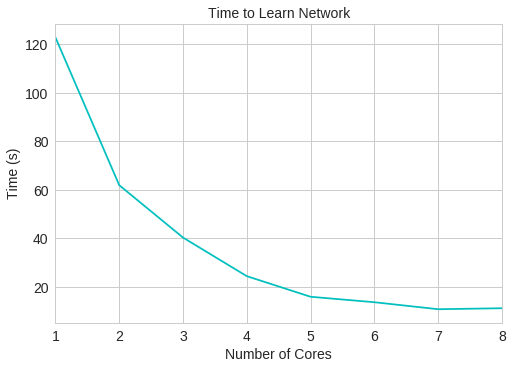

In [8]:
times = []
for i in range(1, 9):
    tic = time.time()
    BayesianNetwork.from_samples(market_data, algorithm='exact', constraint_graph=cg, state_names=names, n_jobs=i)
    times.append(time.time() - tic)

plt.title("Time to Learn Network", fontsize=14)
plt.plot(range(1, 9), times, c='c')
plt.xlabel("Number of Cores", fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel("Time (s)", fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(1, 8)

## 4.2 Constraint Graphs Allow Learning of Bayesian Network Classifiers

This section focused on specifying a Bayesian network classifier using a constraint graph and demonstrating that the learned classifier was a good model.

In [16]:
from sklearn.datasets import load_digits
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

First we load the data, split it into a training and a testing set, and binarize it based on the mean intensity in the training data set.

In [17]:
X, y = load_digits(10, True)

X_train = X[:1500]
y_train = y[:1500]

X_test = X[1500:]
y_test = y[1500:]

mu = X_train.mean()
X_train = X_train > mu
X_test = X_test > mu

Now we fit a multinomial naive Bayes model, a random forest classifier, and the constraint graph to the data and return the results.

In [18]:
print "Multinomial naive Bayes (sklearn)"
tic = time.time()
clf = MultinomialNB().fit(X_train, y_train)
t = time.time() - tic
print "Accuracy: {:4.4}".format(clf.score(X_test, y_test))
print "Time: {:4.4}".format(t)
print "\n"

print "Random forest (sklearn)"
tic = time.time()
clf = RandomForestClassifier(100).fit(X_train, y_train)
t = time.time() - tic
print "Accuracy: {:4.4}".format(clf.score(X_test, y_test))
print "Time: {:4.4}".format(t)
print "\n"

cg = networkx.DiGraph()
cg.add_edge((64,), tuple(range(64)))

X_train = numpy.hstack((X_train, y_train.reshape(1500, 1)))
X_test = numpy.hstack((X_test, y_test.reshape(297, 1)))

tic = time.time()
model = BayesianNetwork.from_samples(X_train, algorithm='exact', constraint_graph=cg)
t = time.time() - tic

y_pred = numpy.zeros(297)
for i in range(297):
    y_pred[i] = model.predict_proba({model.states[j].name: X_test[i, j] for j in range(64)})[64].mle()

print "Bayesian network classifier (pomegranate)"
print "Accuracy: {:4.4}".format((y_pred == y_test).mean())
print "Time: {:4.4}".format(t)
print "\n"

Multinomial naive Bayes (sklearn)
Accuracy: 0.7879
Time: 0.03569


Random forest (sklearn)
Accuracy: 0.8923
Time: 1.888


Bayesian network classifier (pomegranate)
Accuracy: 0.8114
Time: 1.137


